<h1><center>SpaGCN Tutorial</center></h1>


<center>Author: Jian Hu*, Xiangjie Li, Kyle Coleman, Amelia Schroeder, David Irwin, Edward B. Lee, Russell T. Shinohara, Mingyao Li*

### 0. Installation
To install SpaGCN package you must make sure that your python version is over 3.5.=. If you don’t know the version of python you can check it by:

In [1]:
import platform
platform.python_version()

'3.7.9'

Note: Because SpaGCN pends on pytorch, you should make sure torch is correctly installed.
<br>
Now you can install the current release of SpaGCN by the following three ways:
- PyPI: Directly install the package from PyPI.

In [4]:
"""
pip3 install SpaGCN
#Note: you need to make sure that the pip is for python3，or we should install SpaGCN by
python3 -m pip install SpaGCN
pip3 install SpaGCN
#If you do not have permission (when you get a permission denied error), you should install SpaGCN by
pip3 install --user SpaGCN
"""

'\npip3 install SpaGCN\n#Note: you need to make sure that the pip is for python3，or we should install SpaGCN by\npython3 -m pip install SpaGCN\npip3 install SpaGCN\n#If you do not have permission (when you get a permission denied error), you should install SpaGCN by\npip3 install --user SpaGCN\n'

- Github
Download the package from Github and install it locally:

In [5]:
"""
git clone https://github.com/jianhuupenn/SpaGCN
cd SpaGCN/SpaGCN_package/
python3 setup.py install --user
"""

'\ngit clone https://github.com/jianhuupenn/SpaGCN\ncd SpaGCN/SpaGCN_package/\npython3 setup.py install --user\n'

- Anaconda
If you do not have Python3.5 or Python3.6 installed, consider installing Anaconda (see Installing Anaconda). After installing Anaconda, you can create a new environment, for example, SpaGCN (you can change to any name you like).

In [7]:
"""
#create an environment called SpaGCN
conda create -n SpaGCN python=3.7.9
#activate your environment 
conda activate ItClust
git clone https://github.com/jianhuupenn/SpaGCN
cd SpaGCN/SpaGCN_package/
python3 setup.py build
python3 setup.py install
conda deactivate
"""

'\n#create an environment called SpaGCN\nconda create -n SpaGCN python=3.7.9\n#activate your environment \nconda activate ItClust\ngit clone https://github.com/jianhuupenn/SpaGCN\ncd SpaGCN/SpaGCN_package/\npython3 setup.py build\npython3 setup.py install\nconda deactivate\n'

### 1. Import python modules

In [2]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
#pip3 install scikit-image
from skimage import io, color
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt

### 2. Read in data
The current version of SpaGCN requres three input data: 
<br>
1. The gene expression matrix(n by k); 
<br>
2. Spatial coordinateds of samples; 
<br>
3. Histology image(optional).
<br>
The gene expreesion data can be stored as an AnnData object. AnnData stores a data matrix .X together with annotations of observations .obs, variables .var and unstructured annotations .uns. 

In [18]:
"""
#Read original data and save it to h5ad
from scanpy import read_10x_h5
adata = read_10x_h5("../tutorial/data/expression_matrix.h5")
spatial=pd.read_csv("../tutorial/data/positions.txt",sep=",",header=None,na_filter=False,index_col=0) 
adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]
#Select captured samples
adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
adata.write_h5ad("../tutorial/data/sample_data.h5ad")
"""
#Read in gene expression and spatial location
adata=sc.read("../tutorial/data/sample_data.h5ad")
#Read in hitology image
#image=io.imread("../tutorial/data/histology.tif")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### 3. Calculate adjacent matrix

In [3]:
b=49
a=1
#Spot coordinates
x2=adata.obs["x2"].tolist()
x3=adata.obs["x3"].tolist()
#Pixel coordinates
x4=adata.obs["x4"].tolist()
x5=adata.obs["x5"].tolist()
adj=spg.calculate_adj_matrix(x=x2,y=x3, x_pixel=x4, y_pixel=x5, image=image, beta=b, alpha=a, histology=True)
#np.savetxt('../tutorial/data/adj.csv', adj, delimiter=',')

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  46.84205750749746 174.55510595352243 33.30687202862215
Var of x,y,z =  390.6990007265343 942.1320230796399 942.1320230796397
Calculating spot  0
Calculating spot  500
Calculating spot  1000
Calculating spot  1500
Calculating spot  2000
Calculating spot  2500
Calculating spot  3000
Calculating spot  3500


### 4. Run SpaGCN

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Initializing cluster centers with louvain, resolution =  0.65
Epoch  0
delta_label  0.00494641384995878 < tol  0.005
Reach tolerance threshold. Stopping training.


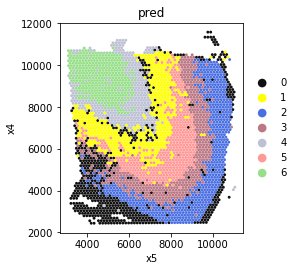

In [3]:
#Set seed
random.seed(200)
torch.manual_seed(200)
np.random.seed(200)
#The clustering results may not be exactly the same
adata=sc.read("../tutorial/data/sample_data.h5ad")
adj=np.loadtxt('../tutorial/data/adj.csv', delimiter=',')
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI-------
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
#Set percentage of total expression contributed by neighborhoods
p=0.5
#Find l
#spg.test_l(adj,[0.5,0.8,1,1.2])
"""
l is  0.5 Percentage of total expression contributed by neighborhoods: 0.022694894646745123
l is  0.8 Percentage of total expression contributed by neighborhoods: 0.5607284420349321
l is  1 Percentage of total expression contributed by neighborhoods: 2.0466495056643024
l is  1.2 Percentage of total expression contributed by neighborhoods: 5.558170663311434
"""
#Therefore,search l around 0.8
#l=spg.find_l(p=p,adj=adj,start=0.75, end=0.8,sep=0.001, tol=0.01)
l=0.79
res=0.65
clf=spg.SpaGCN()
clf.set_l(l)
#Init using louvain
clf.train(adata,adj,init_spa=True,init="louvain",res=res, louvain_seed=0,tol=5e-3)
#Or init using kmeans
#clf.train(adata,adj,init_spa=True,init="kmeans",n_clusters=7, tol=5e-3)
y_pred, prob=clf.predict()

adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Save
adata.write_h5ad("../tutorial/results.h5ad")

#Plot
colors_use=['#111010', '#FFFF00', '#4a6fe3', '#bb7784', '#bec1d4', '#ff9896', '#98df8a', '#ffbb78', '#2ca02c', '#ff7f0e', '#1f77b4', '#800080', '#959595', '#ffff00', '#014d01', '#0000ff', '#ff0000', '#000000']
num_celltype=len(adata.obs["pred"].unique())
adata.uns["pred_colors"]=list(colors_use[:num_celltype])
fig=sc.pl.scatter(adata,alpha=1,x="x5",y="x4",color="pred",show=False,size=120000/adata.shape[0])
fig.set_aspect('equal', 'box')
fig.figure.savefig("../tutorial/Domains.png", dpi=300)
fig

### 5. Identify SVGs

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


radius= 2 average number of neighbors for each spot is 8.991853360488799
 Cluster 5 has neighbors:
Dmain  1 :  685
Dmain  3 :  280
Domain 5 : ['TMSB10', 'PCP4']


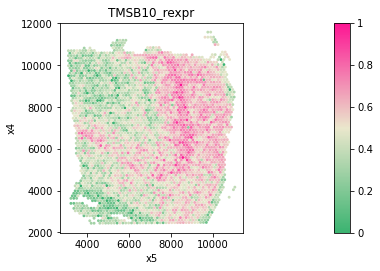

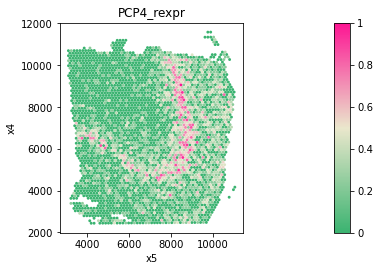

In [5]:
adata=sc.read("../tutorial/results.h5ad")
pred=adata.obs["pred"].astype('category')
raw=sc.read("../tutorial/data/sample_data.h5ad")
raw.var_names_make_unique()
raw.obs["pred"]=pred
#Convert sparse matrix to non-sparse
raw.X=(raw.X.A if issparse(raw.X) else raw.X)
#set adata.raw
raw.raw=raw
sc.pp.log1p(raw)

#Using domain 5 as an example
min_in_group_fraction=0.8
min_in_out_group_ratio=1
min_fold_change=1.5
target=5
nbr_domians=spg.find_neighbor_clusters(target_cluster=target,
                                   cell_id=raw.obs.index.tolist(), 
                                   x=raw.obs["x2"].tolist(), 
                                   y=raw.obs["x3"].tolist(), 
                                   pred=raw.obs["pred"].tolist(),
                                   radius=2,
                                   ratio=1/2)
nbr_domians=nbr_domians[0:3]
de_genes_info=spg.rank_genes_groups(input_adata=raw,
                                target_cluster=target,
                                nbr_list=nbr_domians, 
                                label_col="pred", 
                                adj_nbr=True, 
                                log=True)
de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
#de_genes_info=de_genes_info.sort_values(by="in_group_fraction", ascending=False)
filtered_info=de_genes_info
filtered_info=filtered_info[(filtered_info["pvals_adj"]<0.05) &
(filtered_info["in_out_group_ratio"]>=min_in_out_group_ratio) &
(filtered_info["in_group_fraction"]>=min_in_group_fraction) &
(filtered_info["fold_change"]>=min_fold_change)]
filtered_info=filtered_info.sort_values(by="in_group_fraction", ascending=False)
SVG=filtered_info["genes"].tolist()

print("Domain", target,":", SVG)

#Plot SVG
import matplotlib.colors as clr
import matplotlib.pyplot as plt
color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
#Plot some SVGs
for g in SVG:
    fig=spg.plot_relative_exp(raw, g, "x5", "x4", use_raw=True,color=color_self,spot_size=120000)
    fig.set_aspect('equal', 'box')
    fig.figure.savefig("../tutorial/"+g+"_raw_relative.png", dpi=300)


### 6. Identify Meta Gene

In [6]:
adata=sc.read("../tutorial/results.h5ad")
pred=adata.obs["pred"].astype('category')
raw=sc.read("./data/sample_data.h5ad")
raw.var_names_make_unique()
raw.obs["pred"]=pred
#Convert sparse matrix to non-sparse
raw.X=(raw.X.A if issparse(raw.X) else raw.X)
#set adata.raw
raw.raw=raw
sc.pp.log1p(raw)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
#Use domain 0 as an example
target=0
meta_name, meta_exp=spg.find_meta_gene(input_adata=raw,
                    pred=raw.obs["pred"].tolist(),
                    target_domain=target,
                    start_gene="KRT8",
                    mean_diff=0,
                    early_stop=True,
                    max_iter=5,
                    use_raw=False)

raw.obs["meta"]=meta_exp

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Add gene:  MYL9
Minus gene:  FTH1
Absolute mean change: 0.8869066
Number of non-target spots reduced to: 1091
Meta gene is:  KRT8+MYL9-FTH1


Trying to set attribute `.obs` of view, copying.


Add gene:  MGP
Minus gene:  MBP
Absolute mean change: 2.1050348
Number of non-target spots reduced to: 286
Meta gene is:  KRT8+MYL9-FTH1+MGP-MBP


Trying to set attribute `.obs` of view, copying.


Add gene:  GFAP
Minus gene:  SNAP25
Absolute mean change: 2.6333575
Number of non-target spots reduced to: 181
Meta gene is:  KRT8+MYL9-FTH1+MGP-MBP+GFAP-SNAP25


Trying to set attribute `.obs` of view, copying.


Add gene:  SLC1A2
Minus gene:  PLP1
Absolute mean change: 3.3762903
Number of non-target spots reduced to: 87
Meta gene is:  KRT8+MYL9-FTH1+MGP-MBP+GFAP-SNAP25+SLC1A2-PLP1
Add gene:  PLP1
Minus gene:  CALM2
Stopped! Previous Number of non-target spots 87 110 3.3762903 3.1888924
Previous Number of non-target spots 87 110 3.3762903 3.1888924
Previous Number of non-target spots 87
Current Number of non-target spots 110
Absolute mean change 3.3762903
Meta gene:  KRT8+MYL9-FTH1+MGP-MBP+GFAP-SNAP25+SLC1A2-PLP1


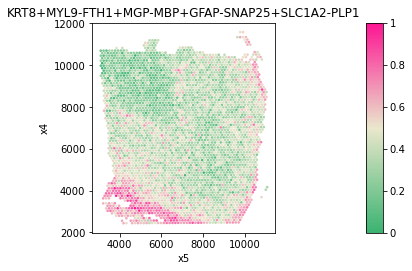

In [8]:
#Plot meta gene relative expression 
raw.obs["meta_relative"]=(raw.obs["meta"]-np.min(raw.obs["meta"]))/(np.max(raw.obs["meta"])-np.min(raw.obs["meta"]))
color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
fig=sc.pl.scatter(raw, x="x5", y="x4", color="meta_relative",title=meta_name,color_map=color_self,show=False,size=100000/raw.shape[0])
fig.set_aspect('equal', 'box')
fig
fig.figure.savefig("../tutorial/"+meta_name+"_raw_relative.png", dpi=300)


### 7. Identify Subdomain

In [13]:
#Use domain 5 as an example since it is located in the centre
adata=sc.read("../tutorial/results.h5ad")
pred=adata.obs["pred"].astype('category')
raw=sc.read("./data/sample_data.h5ad")
raw.var_names_make_unique()
raw.obs["pred"]=pred
target=5
raw.obs["sub_cluster"]=spg.detect_subclusters(cell_id=raw.obs.index.tolist(), 
                               x=raw.obs["x2"].tolist(), 
                               y=raw.obs["x3"].tolist(), 
                               pred=raw.obs["pred"].tolist(), 
                               target_cluster=target, 
                               radius=3, 
                               res=0.1)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


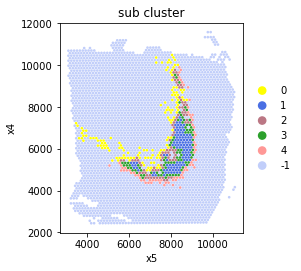

In [16]:
colors_use=['#FFFF00', '#4a6fe3', '#bb7784', '#2ca02c', '#ff9896', "#C1CEFA",'#98df8a', '#ffbb78', '#ff7f0e', '#1f77b4', '#800080', '#959595', '#ffff00', '#014d01', '#0000ff', '#ff0000', '#000000']
num_celltype=len(raw.obs["sub_cluster"].unique())
raw.uns["sub_cluster_colors"]=list(colors_use[:num_celltype])
fig=sc.pl.scatter(raw,alpha=1,x="x5",y="x4",color="sub_cluster",show=False,size=100000/raw.shape[0])
fig.set_aspect('equal', 'box')
fig
fig.figure.savefig("../tutorial/Domain2_subdomains.png", dpi=300)